In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.5 MB/s eta 0:00:00


In [2]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [4]:
goog = df[df['Name'] == 'GOOG']['Close']

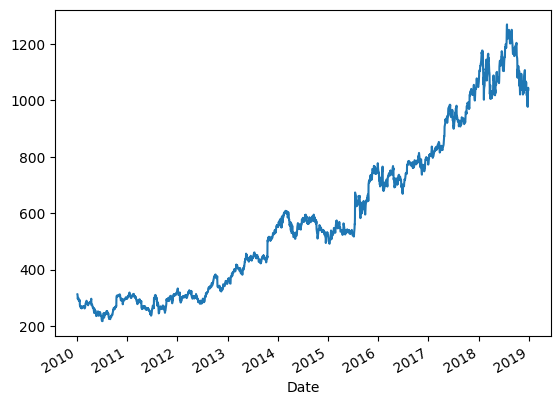

In [5]:
goog.plot();

In [6]:
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

In [7]:
model = pm.auto_arima(train,
                      error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16270.771, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16270.383, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16269.726, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16269.492, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16271.123, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16268.077, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16267.935, Time=1.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16268.277, Time=1.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16266.968, Time=0.94 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16264.983, Time=1.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16266.925, Time=1.97 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16268.907, Time=1.46 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16265.470, Time=0.28 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 11.381 seconds


In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8127.491
Date:                Mon, 28 Aug 2023   AIC                          16264.983
Time:                        18:53:49   BIC                          16293.536
Sample:                             0   HQIC                         16275.409
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3104      0.198      1.571      0.116      -0.077       0.698
ar.L1          0.0378      0.012      3.152      0.002       0.014       0.061
ar.L2         -0.0410      0.013     -3.241      0.001      -0.066      -0.016
ar.L3          0.0488      0.012      4.031      0.000       0.025       0.073
sigma2        85.1623      1.033     82.421      0.000      83.137      87.187
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11790.07
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.78   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
def plot_result(model, fulldata, train, test):
  params = model.get_params()
  d = params['order'][1]

  train_pred = model.predict_in_sample(start=d, end=-1)
  test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(fulldata.index, fulldata, label='data')
  ax.plot(train.index[d:], train_pred, label='fitted')
  ax.plot(test.index, test_pred, label='forecast')
  ax.fill_between(test.index, \
                  confint[:,0], confint[:,1], \
                  color='red', alpha=0.3)
  ax.legend();

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


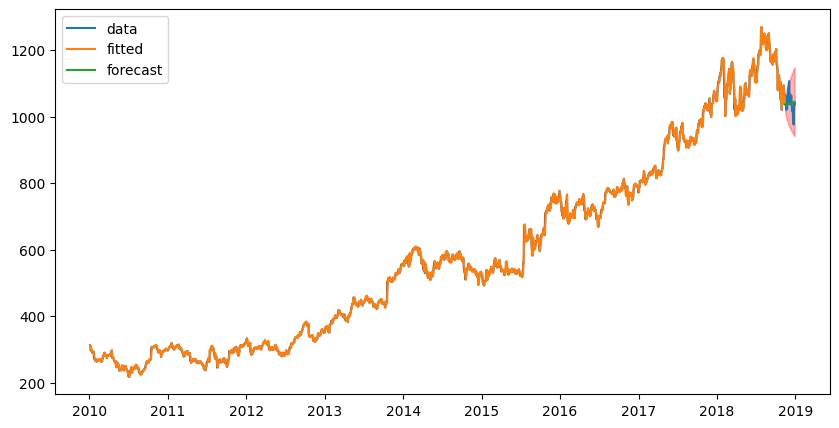

In [10]:
plot_result(model, goog, train, test)

In [11]:
def plot_test(model, test):
  test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(test.index, test, label='true')
  ax.plot(test.index, test_pred, label='forecast')
  ax.fill_between(test.index, \
                  confint[:,0], confint[:,1], \
                  color='red', alpha=0.3)
  ax.legend();

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


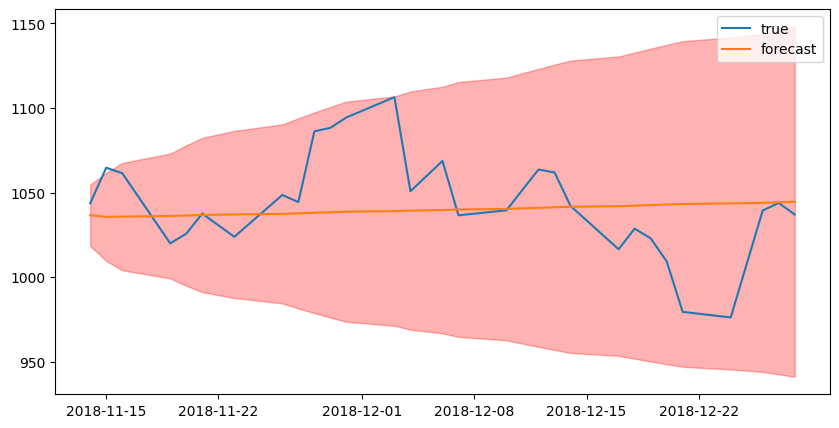

In [12]:
plot_test(model, test)

In [13]:
def rmse(y, t):
  return np.sqrt(np.mean((t - y)**2))

In [14]:
print("RMSE ARIMA:", rmse(model.predict(Ntest), test))
print("RMSE Naive:", rmse(train.iloc[-1], test))

RMSE ARIMA: nan
RMSE Naive: 30.029502477261467


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
